In [5]:
import pandas as pd 
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt 
from sklearn.ensemble import GradientBoostingRegressor
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
%matplotlib inline 
import numpy as np
plt.rcParams['figure.figsize'] = (16, 4)

import warnings
warnings.filterwarnings(action="ignore")
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

#from utils import * # We've added all the functions from the last BLU to the utils.py 

In [6]:
import pmdarima as pm
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

In [8]:
wf1_df = pd.read_csv('data/wf1_data.csv')  
wf2_df = pd.read_csv('data/wf2_data.csv')  
wf3_df = pd.read_csv('data/wf3_data.csv')

In [9]:
wf1_df['date'] = pd.to_datetime(wf1_df.date, format='%Y%m%d%H')
wf2_df['date'] = pd.to_datetime(wf2_df.date, format='%Y%m%d%H')
wf3_df['date'] = pd.to_datetime(wf3_df.date, format='%Y%m%d%H')

In [10]:
wf1_df = wf1_df.set_index('date',    # <---- Set the index to be our timestamp data  
                      drop=True)
wf2_df = wf2_df.set_index('date',    # <---- Set the index to be our timestamp data  
                      drop=True)
wf3_df = wf3_df.set_index('date',    # <---- Set the index to be our timestamp data  
                      drop=True)

In [11]:
data_wf1 = wf1_df[:-24]
vtp_wf1 = wf1_df[-24:]

data_wf2 = wf2_df[:-24]
vtp_wf2 = wf2_df[-24:]

data_wf3 = wf3_df[:-24]
vtp_wf3 = wf3_df[-24:]

In [12]:
data_wf1_r = data_wf1.resample('1H').mean()
missing_values = data_wf1_r[data_wf1_r.isnull()['wp']]

In [14]:
from sklearn.impute import KNNImputer
imputer = KNNImputer() # To obtain better results we may want to have more neighbors, of course that in a real setting
                       # this is a parameter that should be tunned
    
data_imputed = imputer.fit_transform(data_wf1_r) # This may take a bit to run
data_wf1_imputed = pd.DataFrame(data_imputed, index=data_wf1_r.index, columns=data_wf1_r.columns)
data_wf1_imputed

,wp,ws
date,,
2009-07-01 01:00:00,0.085,2.47
2009-07-01 02:00:00,0.020,2.40
2009-07-01 03:00:00,0.060,2.51
2009-07-01 04:00:00,0.045,2.73
2009-07-01 05:00:00,0.035,2.93
...,...,...
2010-06-29 19:00:00,0.737,9.38
2010-06-29 20:00:00,0.802,9.38
2010-06-29 21:00:00,0.827,9.11


<AxesSubplot:xlabel='date'>

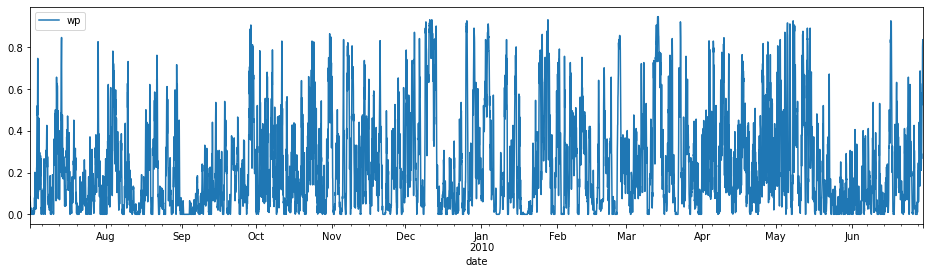

In [15]:
data_wf1_imputed = data_wf1_imputed.sort_index()
data1 = data_wf1_imputed
ws1 = data1.drop(['wp'],axis = 1)
data1 = data1.drop(['ws'],axis = 1)
data1.plot()

In [12]:
30*24

720

In [16]:
data1_c = data1
ws1_c = ws1

In [17]:
data1_s = data1_c[-720:]
ws1_s = ws1_c[-720:]

In [18]:
data1_t_s = data1_s[:-24]
data1_test_s = data1_s[-24:]

data1_val_s = data1_t_s[-24:]
data1_train_s = data1_t_s[:-24]
 
ws1_t_s = ws1_s[:-24]
ws1_test_s = ws1_s[-24:]

ws1_val_s = ws1_t_s[-24:]
ws1_train_s = ws1_t_s[:-24]

In [24]:
data1_t_s

,wp
date,
2010-05-31 00:00:00,0.065
2010-05-31 01:00:00,0.010
2010-05-31 02:00:00,0.000
2010-05-31 03:00:00,0.000
2010-05-31 04:00:00,0.000
...,...
2010-06-28 19:00:00,0.291
2010-06-28 20:00:00,0.687
2010-06-28 21:00:00,0.316


In [19]:
sarimax_pipeline_exog = Pipeline([  #The boxcox transform has been removed because it messes with the exogenous input
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=24, 
                           method='nm',
                           maxiter=20,
                           
                          )
    )
])

sarimax_pipeline_exog.fit(data1_t_s,ws1_t_s)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=-1757.580, Time=2.77 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-1729.067, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=-1747.555, Time=2.27 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=-1752.365, Time=2.10 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-1730.469, Time=0.14 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=-1759.361, Time=2.63 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=-1761.873, Time=0.27 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=-1759.718, Time=2.86 sec
 ARIMA(1,1,2)(0,0,0)[24] intercept   : AIC=-1763.153, Time=0.27 sec
 ARIMA(1,1,2)(1,0,0)[24] intercept   : AIC=-1761.197, Time=2.39 sec
 ARIMA(1,1,2)(0,0,1)[24] intercept   : AIC=-1760.694, Time=2.50 sec
 ARIMA(1,1,2)(1,0,1)[24] intercept   : AIC=-1758.447, Time=2.79 sec
 ARIMA(0,1,2)(0,0,0)[24] intercept   : AIC=-1757.321, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=-1755.989, Time=0.18 sec
 ARIM

Pipeline(steps=[('arima',
                 AutoARIMA(m=24, maxiter=20, method='nm',
                           suppress_warnings=True, trace=True))])

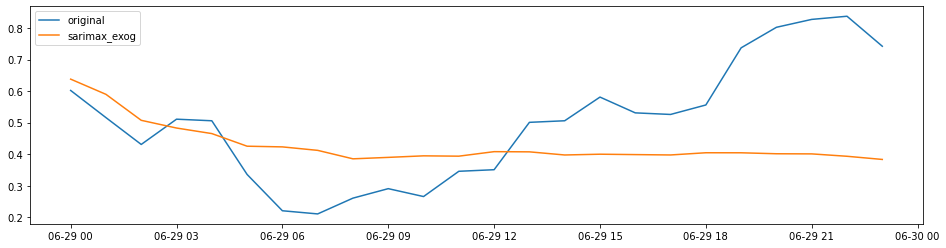

In [20]:
plt.plot(data1_test_s, label='original')
plt.plot(data1_test_s.index, sarimax_pipeline_exog.predict(24,ws1_test_s), label='sarimax_exog')
plt.legend()

In [21]:
sarimax_pipeline_exog.predict(24,ws1_test_s)

array([0.63782917, 0.58970466, 0.50741213, 0.48298332, 0.4654231 ,
       0.42543151, 0.42327357, 0.41227454, 0.38545086, 0.39003511,
       0.39490498, 0.39388191, 0.40816475, 0.40756763, 0.39763952,
       0.40008736, 0.39885658, 0.39769738, 0.40469316, 0.40459918,
       0.40151632, 0.40108785, 0.39354658, 0.38351567])

In [23]:
save('wf1_data', sarimax_pipeline_exog.predict(24,ws1_test_s)) 

'sarimax_pipeline_exog.predict(24,ws1_test_s))' was not found in history, as a file, url, nor in the user namespace.
